In [1]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO

In [2]:
BASE_DIR = '..'
NIGHTLIGHTS_DIR = os.path.join(BASE_DIR, 'data/Nightlights/2013/F182013.v4c_web.stable_lights.avg_vis.tif')
COUNTRY = 'malawi_2016'
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'api_key.txt')

RANDOM_SEED = 7 # for reproducibility
PROCESSED_DIR = os.path.join(BASE_DIR, 'countries', COUNTRY, 'processed')
IMAGE_DIR = os.path.join(BASE_DIR, 'countries', COUNTRY, 'images')

In [3]:
os.makedirs(IMAGE_DIR, exist_ok=False)

# Generate Candidate Download Locations

In [4]:
# these are adapted straight from the original paper

def latLon2Pixel(lat, lon, ct, gt):
    (lon, lat, holder) = ct.TransformPoint(lon, lat)
    x = (lon-gt[0])/gt[1]
    y = (lat-gt[3])/gt[5]
    return (int(x), int(y))


def locsToPixels(srcAddr, latLonPairs):
    ds = gdal.Open(srcAddr)
    gt = ds.GetGeoTransform()
    srs = osr.SpatialReference()
    srs.ImportFromWkt(ds.GetProjection())
    srsLatLong = srs.CloneGeogCS()
    ct = osr.CoordinateTransformation(srsLatLong, srs)
    pixelPairs = []
    for point in latLonPairs:
        lat, lon = point
        pixelPairs.append(latLon2Pixel(lat, lon, ct, gt))
    return pixelPairs


def pixel2coord(x, y, xoff, a, b, yoff, d, e):
    xp = a * x + b * y + xoff
    yp = d * x + e * y + yoff
    return (yp, xp)


def pixelsToCoords(srcAddr, pixelPairs):
    ds = gdal.Open(srcAddr)
    xoff, a, b, yoff, d, e = ds.GetGeoTransform()
    latLonPairs = []
    for pixel in pixelPairs:
        x, y = pixel
        latLonPairs.append(pixel2coord(x + 0.5, y + 0.5, xoff, a, b, yoff, d, e))
    return latLonPairs


def get_download_locations():
    df = pd.read_csv(os.path.join(PROCESSED_DIR, 'clusters.csv'))
    clusters = df[['lat', 'lon']].values.tolist()
    top_lefts = [(lat + 0.045, lon - 0.045) for lat, lon in clusters]
    bottom_rights = [(lat - 0.045, lon + 0.045) for lat, lon in clusters]
    top_left_pixellocs = locsToPixels(NIGHTLIGHTS_DIR, top_lefts)
    bottom_right_pixellocs = locsToPixels(NIGHTLIGHTS_DIR, bottom_rights)
    output_cluster_locs = []
    output_pix = []
    for i in range(len(clusters)):
        top_left = top_left_pixellocs[i]
        bottom_right = bottom_right_pixellocs[i]
        for x in range(top_left[0], bottom_right[0]):
            for y in range(top_left[1], bottom_right[1]):
                output_pix.append((x, y))
                output_cluster_locs.append(clusters[i])

    output_locs = pixelsToCoords(NIGHTLIGHTS_DIR, output_pix)
    save_dir = os.path.join(PROCESSED_DIR, 'candidate_download_locs.csv')
    columns = ['im_lat', 'im_lon', 'cluster_lat', 'cluster_lon']
    with open(save_dir, 'w') as f:
        f.write(','.join(columns) + '\n')
        for loc, cluster_loc in zip(output_locs, output_cluster_locs):
            to_write = ','.join([str(loc[0]), str(loc[1]), str(cluster_loc[0]), str(cluster_loc[1])]) + '\n'
            f.write(to_write)
        print(f'{len(output_locs)} locations saved at {save_dir}')


In [5]:
print(f"Generating candidate image locations for {COUNTRY}")
get_download_locations()

Generating candidate image locations for malawi_2016
90943 locations saved at ../countries/malawi_2016/processed/candidate_download_locs.csv


In [6]:
df_potential_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'candidate_download_locs.csv'))
df_potential_download.head()

,im_lat,im_lon,cluster_lat,cluster_lon
0,-17.050000,35.174999,-17.09515,35.217213
1,-17.058333,35.174999,-17.09515,35.217213
2,-17.066666,35.174999,-17.09515,35.217213
3,-17.075000,35.174999,-17.09515,35.217213
4,-17.083333,35.174999,-17.09515,35.217213


In [7]:
df_potential_download.shape

(90943, 4)

In [8]:
df_clusters = pd.read_csv(os.path.join(PROCESSED_DIR, 'clusters.csv'))
df_clusters.rename(columns={'lat': 'cluster_lat', 'lon': 'cluster_lon'}, inplace=True)

In [9]:
df_clusters.head()

,cluster_lat,cluster_lon,cons_pc,nightlights
0,-17.095150,35.217213,1.477796,0.000000
1,-17.092351,35.114643,1.314741,0.000000
2,-17.016698,35.079629,1.626932,0.000000
3,-16.977243,35.205706,1.733232,0.121212
4,-16.956385,35.168967,1.131669,0.502674


In [10]:
def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon']):
    """
        Allows two dataframes to be merged on lat/lon
        Necessary because pandas has trouble merging on floats
    """
    df1 = df1.copy()
    df2 = df2.copy()
    
    # must use ints for merging, as floats induce errors
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)
    
    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)
    
    df2.drop(keys, axis=1, inplace=True)
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'])
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)
    return merged

In [11]:
prev_len = len(df_potential_download)
df_potential_download = merge_on_lat_lon(df_potential_download, df_clusters)
assert len(df_potential_download) == prev_len

In [12]:
df_potential_download.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,-17.050000,35.174999,-17.09515,35.217213,1.477796,0.0
1,-17.058333,35.174999,-17.09515,35.217213,1.477796,0.0
2,-17.066666,35.174999,-17.09515,35.217213,1.477796,0.0
3,-17.075000,35.174999,-17.09515,35.217213,1.477796,0.0
4,-17.083333,35.174999,-17.09515,35.217213,1.477796,0.0


# Filter Download Choices

In [13]:
# most nightlights are 0
# let's download images that have nonzero nightlights to induce variety into the model
print((df_potential_download['nightlights'] == 0).mean())
print((df_potential_download['nightlights'] <= 2).mean())

0.4980042444168325
0.5345253217649738


In [14]:
def drop_0s(df, fr=0.1, min_clust_images=10):
    """
        Solves for d:
            (c_z - d)/(n - d) = fr
        Where c_z = count_zero, n = num_rows, fr = frac_remaining
        
        Yields:
        d = (c - n*fr) / (1 - fr)
    """
    np.random.seed(RANDOM_SEED)
    c_z = (df['nightlights']==0).sum()
    n = len(df)
    assert c_z / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_z - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    zero_df = df[df['nightlights']==0]
    zero_clusters = zero_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(zero_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster with 0 nightlights')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in zero_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= min_clust_images, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
    
    # this is how you do it purely randomly but some clusters might get wiped out
    # z_inds = np.argwhere(df['nightlights'].values == 0).reshape(-1)
    # drop_inds = np.random.choice(z_inds, d, replace=False)
    return df.drop(drop_inds).reset_index(drop=True)

def drop_in_range(df, lower=0, upper=2, fr=0.25, min_clust_images=10):
    """
        Very similar to drop_0s calculation, but more generalized
    """
    np.random.seed(RANDOM_SEED)
    boolean_idx = ((lower <= df['nightlights']) & (df['nightlights'] <= upper))
    c_under = boolean_idx.sum()
    n = len(df)
    assert c_under / n > fr, print(f'Dataframe already has under {fr} zeros')
    
    d = (c_under - n * fr) / (1 - fr)
    d = int(d)
    print(f'dropping: {d}')
    
    select_df = df[boolean_idx]
    select_clusters = select_df.groupby(['cluster_lat', 'cluster_lon'])
    per_cluster_drop = int(d / len(select_clusters))
    print(f'Need to drop {per_cluster_drop} per cluster in the given nightlight range')
    
    drop_inds = []
    for (cluster_lat, cluster_lon), group in select_clusters:
        z_inds = group.index
        clust_drop = np.random.choice(z_inds, per_cluster_drop, replace=False)
        assert len(group) - len(clust_drop) >= min_clust_images, print(f'dropping too many in {cluster_lat}, {cluster_lon}')
        drop_inds += clust_drop.tolist()
        
    return df.drop(drop_inds).reset_index(drop=True)


In [15]:
df_mod_download = drop_0s(df_potential_download, fr=0.2)

dropping: 33876
Need to drop 86 per cluster with 0 nightlights


In [16]:
(df_mod_download['nightlights'] == 0).mean()

0.20469313450516524

In [17]:
df_mod_download = drop_in_range(df_mod_download, lower=0.001, upper=3, fr=0.25)

dropping: 18687
Need to drop 77 per cluster in the given nightlight range


In [18]:
((0.001 <= df_mod_download['nightlights']) & (df_mod_download['nightlights'] <= 3)).mean()

0.25102530372204596

In [19]:
# this has gone up now though
(df_mod_download['nightlights'] == 0).mean()

0.3030772008563543

In [20]:
df_mod_download = drop_0s(df_mod_download, fr=0.3)

dropping: 170
Need to drop 0 per cluster with 0 nightlights


In [21]:
df_mod_download.shape

(38769, 6)

In [22]:
# no clusters lost
len(df_mod_download.groupby(['cluster_lat', 'cluster_lon']))

780

In [23]:
df_mod_download.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights
0,-17.050000,35.174999,-17.09515,35.217213,1.477796,0.0
1,-17.108333,35.174999,-17.09515,35.217213,1.477796,0.0
2,-17.116666,35.174999,-17.09515,35.217213,1.477796,0.0
3,-17.075000,35.183332,-17.09515,35.217213,1.477796,0.0
4,-17.058333,35.191666,-17.09515,35.217213,1.477796,0.0


In [24]:
from sklearn.mixture import GaussianMixture as GMM
X = df_mod_download['nightlights'].values.reshape(-1,1)
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(df_mod_download['nightlights'].values.reshape(-1,1))

In [25]:
(labels==0).mean(), (labels==1).mean(), (labels==2).mean()

(0.3030772008563543, 0.07944491733085712, 0.6174778818127886)

In [26]:
# these are the cutoff for the labels identified by the Guassian Mixture Model
label0_max = df_mod_download['nightlights'][labels==0].max()
label1_max = df_mod_download['nightlights'][labels==1].max()
label2_max = df_mod_download['nightlights'][labels==2].max()

label0_max, label1_max, label2_max

(0.0, 48.413223140495866, 14.8099173553719)

In [27]:
# I am going to hand reassign these because "0" is its own category still
label0_max = 3
label1_max = 48.5
label2_max = 13

In [28]:
# these are not ideal distributions obviously but the model should be able to learn still
def query_df(df, lower, upper):
    return df[((lower <= df['nightlights']) & (df['nightlights'] <= upper))]

print(len(query_df(df_mod_download, 0, label0_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label0_max, label2_max)) / len(df_mod_download))
print(len(query_df(df_mod_download, label2_max, label1_max)) / len(df_mod_download))

0.5541025045784003
0.36333152776703037
0.08256596765456937


In [29]:
def create_nightlights_bin(df, cutoffs):
    assert len(cutoffs) >= 2, print('need at least 2 bins')
    cutoffs = sorted(cutoffs, reverse=True)
    print(cutoffs)
    df['nightlights_bin'] = len(cutoffs)
    for i in range(len(cutoffs)):
        label = len(cutoffs) - i # highest nightlight gets value NUM_CLASS, lowest gets value 1
        df['nightlights_bin'].loc[df['nightlights'] <= cutoffs[i]] = label

df_download = df_mod_download.copy()
create_nightlights_bin(df_download, cutoffs=[label0_max, label1_max, label2_max])

[48.5, 13, 3]


/opt/anaconda3/envs/predicting-poverty-replication/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [30]:
# these should match above
(df_download['nightlights_bin']==1).mean(), (df_download['nightlights_bin']==2).mean(), (df_download['nightlights_bin']==3).mean()


(0.5541025045784003, 0.36333152776703037, 0.08256596765456937)

In [31]:
df_download['image_name'] = df_download['im_lat'].astype(str) + '_' + df_download['im_lon'].astype(str) + '.png'

In [32]:
df_download.head()

,im_lat,im_lon,cluster_lat,cluster_lon,cons_pc,nightlights,nightlights_bin,image_name
0,-17.050000,35.174999,-17.09515,35.217213,1.477796,0.0,1,-17.04999963180002_35.17499913930001.png
1,-17.108333,35.174999,-17.09515,35.217213,1.477796,0.0,1,-17.10833296490002_35.17499913930001.png
2,-17.116666,35.174999,-17.09515,35.217213,1.477796,0.0,1,-17.116666298200016_35.17499913930001.png
3,-17.075000,35.183332,-17.09515,35.217213,1.477796,0.0,1,-17.07499963170001_35.1833324726.png
4,-17.058333,35.191666,-17.09515,35.217213,1.477796,0.0,1,-17.058332965100007_35.191665805900016.png


In [33]:
df_download.shape

(38769, 8)

In [34]:
df_download.to_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'), index=False)

# Download Images
If the script breaks, you can restart here by uncommenting the line below and running the below code again. It won't download images you have already downloaded.

In [35]:
# df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [36]:
# there are some duplicates, there is no need to download those twice
actual_download = df_download.drop_duplicates(['im_lat', 'im_lon'])
actual_download.shape

(22819, 8)

In [37]:
"""Interface for downloading aerial imagery from Google Static Maps API.
- Get an API key at https://developers.google.com/maps/documentation/maps-static/intro
"""
class ImageryDownloader:
    def __init__(self, access_token):
        self.access_token = access_token
        self.url = 'https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom={}&size=400x400&maptype=satellite&key={}'
    
    def download(self, lat, long, zoom):
        res = requests.get(self.url.format(lat, long, zoom, self.access_token))
        # server needs to make image available, takes a few seconds
        if res.status_code == 403:
            return 'RETRY'
        assert res.status_code < 400, print(f'Error - failed to download {lat}, {long}, {zoom}')
        image = plt.imread(BytesIO(res.content))
        return image

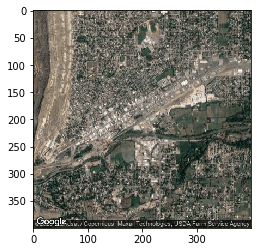

In [38]:
# this demonstrates the API call
lat = 38.441332
lon = -105.234751

access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0]
url = "https://maps.googleapis.com/maps/api/staticmap?center={},{}&zoom=14&size=400x400&maptype=satellite&key={}".format(lat, lon, access)
res = requests.get(url)
plt.imshow(plt.imread(BytesIO(res.content)))

In [39]:
def download_images(df):
    """
        Download images using a pandas DataFrame that has "im_lat", "im_lon", "image_name" as columns
    """
    ACCESS_TOKEN = None
    with open(ACCESS_TOKEN_DIR, 'r') as f:
        ACCESS_TOKEN = f.readlines()[0]
    imd = ImageryDownloader(ACCESS_TOKEN)
    zoom = 16
    NUM_RETRIES = 20
    WAIT_TIME = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(IMAGE_DIR)
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))

    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.im_lat
        lon = r.im_lon
        name = r.image_name
        try:
            im = imd.download(lat, lon, zoom)
            if type(im) == str and im == 'RETRY':
                resolved = False
                for _ in range(NUM_RETRIES):
                    time.sleep(WAIT_TIME)
                    im = imd.download(lat, lon, zoom)
                    if type(im) == str and im == 'RETRY':
                        continue
                    else:
                        plt.imsave(os.path.join(IMAGE_DIR, name), im)
                        resolved = True
                        break
                if not resolved:
                    raise ValueError(f'Could not download {lat}, {lon}, {zoom} despite several retries and waiting')
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(os.path.join(IMAGE_DIR, name), im)

        except Exception as e:
            logging.error(f"Error-could not download {lat}, {lon}, {zoom}", exc_info=True)
            break

In [40]:
download_images(actual_download)

Already downloaded 0
Need to download 22819
